<a href="https://colab.research.google.com/github/jefersondaniel/machine-learning-studies/blob/master/examples/convnet/inception_v3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==1.14.0 keras==2.1.6 numpy scikit-learn kaggle

In [2]:
import io, os
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

done = False
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
request = drive_service.files().get_media(fileId=results['files'][0]['id'])
downloader = MediaIoBaseDownload(io.FileIO(filename, 'wb'), request)

while not done:
    status, done = downloader.next_chunk()
    print("Download {}%.".format(int(status.progress() * 100)))

os.chmod(filename, 600)

Download 100%.


In [3]:
!mkdir -p /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle.json': No such file or directory


In [0]:

!kaggle datasets download jefersondaniel/simple-image-detection-3-classes
!unzip simple-image-detection-3-classes.zip -d objects

In [9]:
import glob
import pandas as pd

df = pd.DataFrame(glob.glob('objects/**/*.jpg'), columns=['filepath'])
df['object'] = df['filepath'].apply(lambda x: x.split('/')[1])

df = df.sample(frac=1)
df = df.reset_index(drop=True)
display(df.head())
display(df.groupby('object').count())


,filepath,object
0,objects/glass/c4u5cl-50ml-ce-disposable-shot-g...,glass
1,objects/water_bottle/ti-water-bottle-black-lid...,water_bottle
2,objects/glass/24007-preview-01-5a1036d8a0a4e.jpg,glass
3,objects/glass/c61414ecf73494d6377b10a1d112f45a...,glass
4,objects/glass/empty-beer-glass-19354876.jpg,glass


,filepath
object,
chair,179
glass,151
water_bottle,121


(16, 299, 299, 3)

(16, 3)

3

'chair'

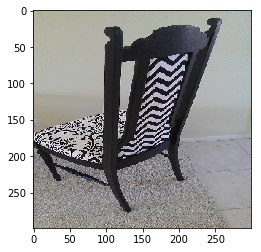

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras_preprocessing import image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.applications.inception_v3 import preprocess_input

K.set_image_dim_ordering("tf")

classes = sorted(list(df['object'].unique()))
lb = LabelBinarizer()
lb.fit(classes)

NB_CLASSES = len(classes)

X = df['filepath']
y = lb.transform(df['object'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

def image_generator(X, y, batch_size):
  iterx = enumerate(X)

  while True:
    images = []
    labels = []

    while len(images) < batch_size:
      try:
        index, filepath = next(iterx)
      except StopIteration:
        iterx = enumerate(X)
        continue

      try:
        img = image.load_img(filepath, target_size=(299, 299))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
      except IOError:
        continue

      images.append(img)
      labels.append(y[index])

    images = np.array(images)
    images = np.vstack(images)
    labels = np.array(labels)

    yield (images, labels)

batch = next(image_generator(X_train, y_train, 16))
display(batch[0].shape)
display(batch[1].shape)
display(len(classes))

idx = 7
plt.imshow((batch[0][idx] + 1) / 2)
display(classes[np.argmax(batch[1][idx])])

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD

base_model = InceptionV3(include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NB_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

optimizer = SGD(lr=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

W0801 17:32:51.217732 140499992733568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 17:32:51.234546 140499992733568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 17:32:51.238525 140499992733568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 17:32:51.258287 140499992733568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:168: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0801 17:32:51.259388 1404999927

87916544/87910968 [==============================] - 2s 0us/step


W0801 17:33:08.172178 140499992733568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

W0801 17:33:43.887724 140499992733568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3/2 [========================================] - 29s 10s/step - loss: 1.1003 - acc: 0.3646 - val_loss: 0.8900 - val_acc: 0.5703
Epoch 2/10
3/2 [========================================] - 13s 4s/step - loss: 0.8136 - acc: 0.6484 - val_loss: 0.4615 - val_acc: 0.9844
Epoch 3/10
3/2 [========================================] - 13s 4s/step - loss: 0.4989 - acc: 0.9401 - val_loss: 0.2191 - val_acc: 0.9844
Epoch 4/10
3/2 [========================================] - 13s 4s/step - loss: 0.2913 - acc: 0.9635 - val_loss: 0.1126 - val_acc: 0.9688
Epoch 5/10
3/2 [========================================] - 12s 4s/step - loss: 0.1836 - acc: 0.9740 - val_loss: 0.0656 - val_acc: 0.9922
Epoch 6/10
3/2 [========================================] - 13s 4s/step - loss: 0.1203 - acc: 0.9896 - val_loss: 0.0640 - val_acc: 0.9688
Epoch 7/10
3/2 [========================================] - 13s 4s/step - loss: 0.0864 - acc: 0.9948 - val_loss: 0.0660 - val_acc: 0.9688
Epoch 8/10
3/2 [=================

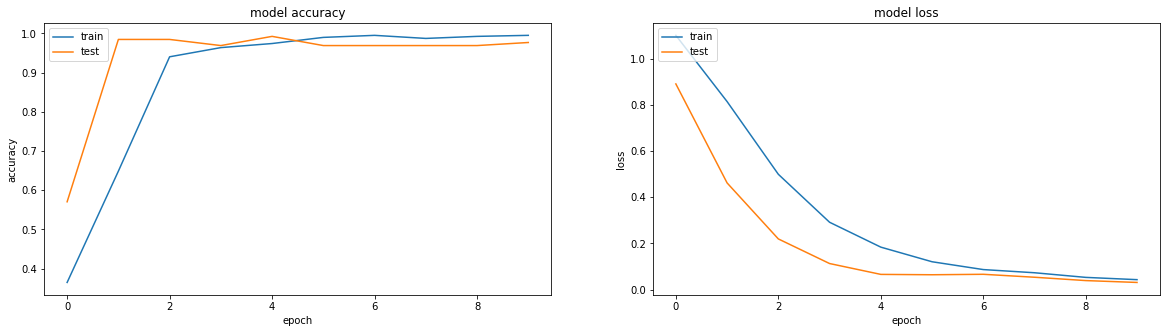

In [16]:
BATCH_SIZE = 128
NB_EPOCH = 10

history = model.fit_generator(
  image_generator(X_train, y_train, batch_size=BATCH_SIZE),
  steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
  validation_data=image_generator(X_val, y_val, batch_size=BATCH_SIZE),
  validation_steps=X_val.shape[0]/BATCH_SIZE,
  epochs=NB_EPOCH
)

score = model.evaluate_generator(
  image_generator(X_test, y_test, batch_size=BATCH_SIZE),
  X_test.shape[0]/BATCH_SIZE,
  use_multiprocessing=False
)

print("Test score: ", score[0])
print("Test accuracy: ", score[1])

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

'glass'

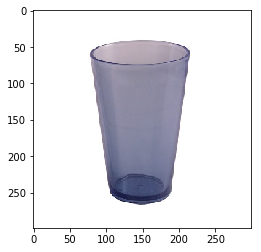

In [47]:
batch = next(image_generator(X_val, y_val, 16))
predictions = [classes[np.argmax(x)] for x in model.predict(batch[0])]

idx = 10
plt.imshow((batch[0][idx] + 1) / 2)
display(predictions[idx])